# SkyWater Inverter Design using GPlugins

The goal of this notebook is to demonstrate the integration of the `sky130nm` electronic PDK within a gdsfactory-based schematic driven layout. Broadly, we will explore:

* A little introduction at setting up the existing open-source electronic EDA development flow with `xschem` using the latest `sky130nm` library
* Exporting that schematic into a SPICE model, which is used to schematic-driven-layout using gdsfactory.
* Example inverter design and layout between the toolsets.

## Using the `gdsfactory-sky130nm` Repository

The goal of this notebook is to show that analogue simulation and layout can be performed together within a `gdsfactory` environment.

```
pip install gplugins[hdl21,sky130]
```

In [1]:
import hdl21 as h
import gdsfactory as gf
import gplugins.hdl21 as gph
import sky130
import sky130_hdl21

from bokeh.io import output_notebook
from gdsfactory.config import rich_output
from gplugins.schematic_editor import SchematicEditor

gf.config.rich_output()

%env BOKEH_ALLOW_WS_ORIGIN=*

output_notebook()

2024-06-02 18:43:57.433 | INFO     | gdsfactory.pdk:register_cells_yaml:376 - Registered cell 'sample'
2024-06-02 18:43:57.753 | WARNING  | pydantic._internal._fields:collect_model_fields:186 - UserWarning: Field name "schema" shadows an attribute in parent "BaseModel"; 
env: BOKEH_ALLOW_WS_ORIGIN=*


Loading BokehJS ...

In [2]:
# sky130.cells

In [3]:
@h.module
class SkyInv:
    """ An inverter, demonstrating using PDK modules """

    # Create some IO
    i, o, VDD, VSS = h.Ports(4)

    p = sky130_hdl21.Sky130MosParams(w=1,l=1)

    # And create some transistors!
    ps = sky130_hdl21.primitives.PMOS_1p8V_STD(p)(d=o, g=i, s=VDD, b=VDD)
    ns = sky130_hdl21.primitives.NMOS_1p8V_STD(p)(d=VSS, g=i, s=o, b=VSS)

### Manually editing the `SPICE`-generated `gdsfactory` component YAML

It is important to know that with the SPICE-generated YAML, we cannot actually create a layout on its own. This is because the SPICE models do not exactly directly map to layout instances. SPICE models can represent performance corners for the same device, with multiple temperature or yield quality variations. As such, we need to assign the corresponding gds we want to layout for our specific schematic model.

In [4]:
example_inverter_manual_yaml = gph.generate_raw_yaml_from_module(
    SkyInv
)
print(example_inverter_manual_yaml)

connections:
  ns,g: ps,g
  ns,s: ps,d
  ps,d: ns,s
  ps,g: ns,g
instances:
  ns:
    component: sky130_fd_pr__nfet_01v8
    info: {}
    settings:
      As: int((nf+2)/2) * w/nf * 0.29
      ad: int((nf+1)/2) * w/nf * 0.29
      l: UNIT_1
      m: UNIT_1
      mult: UNIT_1
      nf: UNIT_1
      nrd: 0.29 / w
      nrs: 0.29 / w
      pd: 2*int((nf+1)/2) * (w/nf + 0.29)
      ports:
        b: VSS
        d: VSS
        g: i
        s: o
      ps: 2*int((nf+2)/2) * (w/nf + 0.29)
      sa: UNIT_0
      sb: UNIT_0
      sd: UNIT_0
      w: UNIT_1
  ps:
    component: sky130_fd_pr__pfet_01v8
    info: {}
    settings:
      As: int((nf+2)/2) * w/nf * 0.29
      ad: int((nf+1)/2) * w/nf * 0.29
      l: UNIT_1
      m: UNIT_1
      mult: UNIT_1
      nf: UNIT_1
      nrd: 0.29 / w
      nrs: 0.29 / w
      pd: 2*int((nf+1)/2) * (w/nf + 0.29)
      ports:
        b: VDD
        d: o
        g: i
        s: VDD
      ps: 2*int((nf+2)/2) * (w/nf + 0.29)
      sa: UNIT_0
      sb: UNIT_0
     

In [5]:


example_inverter_manual_yaml = """
connections:
  ns,d: ps,d
  ns,g: ps,g
  ps,d: ns,d
  ps,g: ns,g
instances:
  ns:
    component: sky130_fd_pr__nfet_01v8
    info: {}
    settings:
      As: int((nf+2)/2) * w/nf * 0.29
      ad: int((nf+1)/2) * w/nf * 0.29
      l: UNIT_1
      m: UNIT_1
      mult: UNIT_1
      nf: UNIT_1
      nrd: 0.29 / w
      nrs: 0.29 / w
      pd: 2*int((nf+1)/2) * (w/nf + 0.29)
      ports:
        b: VSS
        d: o
        g: i
        s: VSS
      ps: 2*int((nf+2)/2) * (w/nf + 0.29)
      sa: UNIT_0
      sb: UNIT_0
      sd: UNIT_0
      w: UNIT_1
  ps:
    component: sky130_fd_pr__pfet_01v8
    info: {}
    settings:
      As: int((nf+2)/2) * w/nf * 0.29
      ad: int((nf+1)/2) * w/nf * 0.29
      l: UNIT_1
      m: UNIT_1
      mult: UNIT_1
      nf: UNIT_1
      nrd: 0.29 / w
      nrs: 0.29 / w
      pd: 2*int((nf+1)/2) * (w/nf + 0.29)
      ports:
        b: VDD
        d: o
        g: i
        s: VDD
      ps: 2*int((nf+2)/2) * (w/nf + 0.29)
      sa: UNIT_0
      sb: UNIT_0
      sd: UNIT_0
      w: UNIT_1
name: SkyInv
ports:
  VDD: ps,s
  VSS: ns,s
  i: ps,g
  o: ps,d
"""
with open("data/sky130nm/example_inverter_manual.schem.yaml", 'w') as file:
        file.write(example_inverter_manual_yaml)

### Automatically mapping layout instances to the YAML

In [6]:
example_inverter_schematic_editor = gph.hdl21_module_to_schematic_editor(
    module=SkyInv,
    yaml_schematic_file_name="data/sky130nm/example_inverter_auto.schem.yaml",
)
example_inverter_schematic_editor.visualize()

Mapping for sky130_fd_pr__pfet_01v8: sky130_fd_pr__rf_pfet_01v8_mcM04W3p00L0p15
2024-06-02 18:43:57.978 | WARNING  | sky130.components:sky130_fd_pr__rf_pfet_01v8_mcM04W3p00L0p15:1318 - UserWarning: decorator is deprecated and will be removed soon. import_gds
Mapping for sky130_fd_pr__nfet_01v8: sky130_fd_pr__rf_nfet_01v8_aM02W1p65L0p15
2024-06-02 18:43:57.994 | WARNING  | sky130.components:sky130_fd_pr__rf_nfet_01v8_aM02W1p65L0p15:526 - UserWarning: decorator is deprecated and will be removed soon. import_gds
2024-06-02 18:43:57.996 | WARNING  | gdsfactory.read.import_gds:import_gds:56 - RuntimeWarning: Unsupported record in file.
2024-06-02 18:43:57.999 | WARNING  | gdsfactory.pdk:get_symbol:438 - UserWarning: prefix is deprecated and will be removed soon. floorplan_with_block_letters
2024-06-02 18:43:58.021 | WARNING  | gdsfactory.read.from_yaml:from_yaml:692 - UserWarning: prefix is deprecated and will be removed soon. _from_yaml
layer (2, 0) not found
layer (0, 0) not found
layer (

[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record type NODETYPE (0x2A) is not supported.
[GDSTK] Record type NODE (0x15) is not supported.
[GDSTK] Record

2024-06-02 18:43:58.063 | WARNING  | pydantic.main:model_dump:314 - UserWarning: Pydantic serializer warnings:
  Expected `str` but got `int` - serialized value may not be as expected
2024-06-02 18:43:58.161 | WARNING  | gdsfactory.component:_write_library:1933 - UserWarning: Component Unnamed_68ce16e9 has invalid transformations. Try component.flatten_offgrid_references() first.
2024-06-02 18:43:58.162 | WARNING  | gdsfactory.component:plot_klayout:1645 - UserWarning: Unnamed cells, 1 in 'Unnamed_68ce16e9'


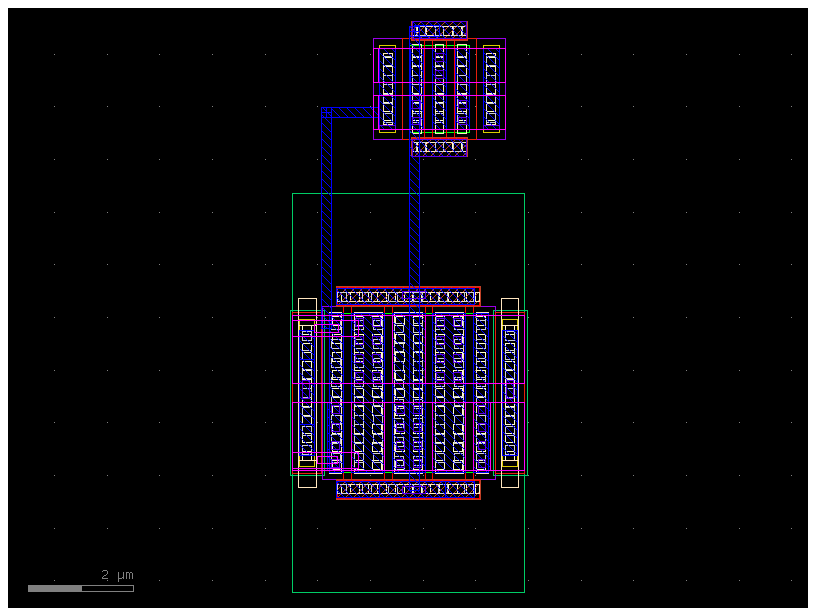

In [7]:
example_inverter_layout = "data/sky130nm/example_inverter_auto.layout.yaml"
example_inverter_schematic_editor.instantiate_layout(example_inverter_layout, default_router="get_bundle", default_cross_section="xs_metal1")
c = gf.read.from_yaml(example_inverter_layout)
c.plot()

## (WIP, future integrations) Setting up the required tools: `xschem`, `volare` and the `sky130nm` PDKs

I will say early on, you would benefit from working in a UNIX or Debian Linux environment. Most EDA tools either proprietary or open-source only work within these operating systems or a Docker environment of these operating systems.

There are multiple ways to get started with the environment, you could, for example:
1. Work within a [IIC-OSIC-TOOLS docker environment](https://github.com/iic-jku/IIC-OSIC-TOOLS). There is also a nice [OSIC-multitool project](https://github.com/iic-jku/osic-multitool) specifically for SKY130nm designs.
2. Install these tools natively in your operating system. You could follow one of these tutorials, for example:
    * https://www.engineerwikis.com/wikis/installation-of-xschem
    * https://www.youtube.com/watch?v=jXmmxO8WG8s&t=7s

This tutorial assumes the tools have already been installed in a local operating system. We will use some design files generated by these toolsets as guided by this [OSIC-Multitool example](https://github.com/iic-jku/osic-multitool/tree/main/example/ana). Note we recommend cloning the `gplugins` repository.

In [8]:
import pathlib
from gplugins.spice import parse_netlist as spice

Our example files are under the directory of `gplugins/notebooks/data`, let's extract our SPICE declaration:

In [9]:
def read_file(file_path):
    try:
        with open(file_path, 'r') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
        return None

Let's list the files we're going to be reading into:

In [10]:
inverter_spice_file = pathlib.Path("data") / "sky130nm" / "inv.sch"

Let's extract our raw spice netlist. An important aspect to understand is that unfortunately, every SPICE tool developed their own file format. So in this sense, netlist parsing function is implemented according to the type of spice toolset that has generated this netlist.

We aim to support:

- `xschem`
- `lumerical?`

In [11]:
inverter_spice_text = read_file(inverter_spice_file)
inverter_spice_text

'v {xschem version=3.0.0 file_version=1.2 }\nG {}\nK {}\nV {}\nS {}\nE {}\nN 720 -800 720 -760 { lab=VSS}\nN 720 -1020 720 -980 { lab=VDD}\nN 720 -950 790 -950 { lab=VDD}\nN 790 -1020 790 -950 { lab=VDD}\nN 720 -830 790 -830 { lab=VSS}\nN 790 -830 790 -760 { lab=VSS}\nN 720 -890 720 -860 { lab=out}\nN 660 -950 680 -950 { lab=in}\nN 660 -890 660 -830 { lab=in}\nN 660 -830 680 -830 { lab=in}\nN 720 -890 880 -890 { lab=out}\nN 720 -1020 790 -1020 { lab=VDD}\nN 720 -760 790 -760 { lab=VSS}\nN 660 -950 660 -890 { lab=in}\nN 720 -920 720 -890 { lab=out}\nN 560 -760 720 -760 { lab=VSS}\nN 560 -890 660 -890 { lab=in}\nN 560 -1020 720 -1020 { lab=VDD}\nC {devices/ipin.sym} 560 -890 0 0 {name=p1 lab=in}\nC {devices/opin.sym} 880 -890 0 0 {name=p2 lab=out\n}\nC {devices/ipin.sym} 560 -1020 0 0 {name=p3 lab=VDD\n}\nC {devices/ipin.sym} 560 -760 0 0 {name=p4 lab=VSS}\nC {sky130_fd_pr/pfet_g5v0d10v5.sym} 700 -950 0 0 {name=M10\n\nL=0.5\nW=8\nnf=2 mult=1\nmodel=pfet_g5v0d10v5\nspiceprefix=X\n}\nC {sk

In [12]:
spice.netlist_text

'\n* Netlist generated with INTERCONNECT on Fri Dec 8 11:06:53 2023\n\n*\n* Component pathname : compound_1\n*\n.subckt COMPOUND_1 PORT_1 PORT_2 PORT_3 PORT_4 PORT_5 PORT_6 PORT_7 PORT_8\n        X_dc_1 PORT_1 PORT_2 N$1 N$3 ebeam_dc_te1550 coupling_length=17.5u sch_x=-0.245 sch_y=1.205 sch_r=0 sch_f=f lay_x=0 lay_y=0\n        X_dc_2 N$1 N$3 PORT_3 PORT_4 ebeam_dc_te1550 coupling_length=17.5u sch_x=0.79 sch_y=0.38 sch_r=0 sch_f=f lay_x=0 lay_y=0\n        X_dc_3 PORT_5 PORT_7 N$11 N$13 ebeam_dc_te1550 coupling_length={%test_param1%*1e-6} sch_x=-1.3 sch_y=-1.585 sch_r=0 sch_f=f lay_x=0 lay_y=0\n        X_ebeam_y_1550_1 N$8 N$13 N$11 ebeam_y_1550 sch_x=0.95 sch_y=-1.58 sch_r=180 sch_f=f lay_x=0 lay_y=0\n        X_ebeam_y_1550_2 N$8 PORT_6 PORT_8 ebeam_y_1550 sch_x=1.89 sch_y=-1.58 sch_r=0 sch_f=f lay_x=0 lay_y=0\n.ends COMPOUND_1\n\n*\n* MAIN CELL: Component pathname : root_element\n*\n        .MODEL ebeam_dc_te1550 radius=5u gap=0.2u note=".- The current model only supports "coupling_len

In [13]:
elements, _, _ = spice.parse_netlist_and_extract_elements(netlist_text=spice.netlist_text, spice_type="lumerical")
elements


[
    {
        'type': 'subckt',
        'name': 'COMPOUND_1',
        'ports': ['PORT_1', 'PORT_2', 'PORT_3', 'PORT_4', 'PORT_5', 'PORT_6', 'PORT_7', 'PORT_8']
    },
    {
        'type': 'component',
        'name': 'ebeam_dc_te1550',
        'component_type': 'X_dc_1',
        'nodes': [
            {'from': 'lay_y=0', 'to': 'PORT_1'},
            {'from': 'lay_y=0', 'to': 'PORT_2'},
            {'from': 'lay_y=0', 'to': 'N$1'},
            {'from': 'lay_y=0', 'to': 'N$3'}
        ],
        'settings': [
            ['coupling_length=17.5u', 'sch_x=-0.245', 'sch_y=1.205', 'sch_r=0', 'sch_f=f', 'lay_x=0'],
            ['coupling_length=17.5u', 'sch_x=0.79', 'sch_y=0.38', 'sch_r=0', 'sch_f=f', 'lay_x=0'],
            [
                'coupling_length={%test_param1%*1e-6}',
                'sch_x=-1.3',
                'sch_y=-1.585',
                'sch_r=0',
                'sch_f=f',
                'lay_x=0'
            ],
            ['sch_x=0.95', 'sch_y=-1.58', 'sch_r=180'

So we can use our `netlist` parsing function to convert this to a compatible netlist for gdsfactory plugins into the extracted elements and the extracted connections:

In [14]:
inverter_netlist_elements, inverter_netlist_connections, _ = spice.parse_netlist_and_extract_elements(netlist_text=inverter_spice_text, spice_type="xschem")
inverter_netlist_elements, inverter_netlist_connections, _


(
    [
        {
            'type': 'component',
            'component_type': 'devices/ipin.sym',
            'position': {'x': '560', 'y': '-890'},
            'name': 'p1',
            'label': 'in',
            'settings': {'name': 'p1', 'lab': 'in'}
        },
        {
            'type': 'component',
            'component_type': 'devices/ipin.sym',
            'position': {'x': '560', 'y': '-760'},
            'name': 'p4',
            'label': 'VSS',
            'settings': {'name': 'p4', 'lab': 'VSS'}
        }
    ],
    [
        {'start': {'x': '720', 'y': '-800'}, 'end': {'x': '720', 'y': '-760'}, 'label': 'VSS'},
        {'start': {'x': '720', 'y': '-1020'}, 'end': {'x': '720', 'y': '-980'}, 'label': 'VDD'},
        {'start': {'x': '720', 'y': '-950'}, 'end': {'x': '790', 'y': '-950'}, 'label': 'VDD'},
        {'start': {'x': '790', 'y': '-1020'}, 'end': {'x': '790', 'y': '-950'}, 'label': 'VDD'},
        {'start': {'x': '720', 'y': '-830'}, 'end': {'x': '790', 'y': '

### Automated schematic-driven-layout

We have now extracted our spice elements and our connectivity. Let's explore what we have there: